# Using Random Survival Forests

This notebook demonstrates how to use [Random Survival Forests](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.ensemble.RandomSurvivalForest.html#sksurv.ensemble.RandomSurvivalForest) introduced in [scikit-survival](https://github.com/sebp/scikit-survival) 0.11.

As it's popular counterparts for classification and regression, a Random Survival Forest is an ensemble
of tree-based learners. A Random Survival Forest ensures that individual trees are de-correlated by 1)
building each tree on a different bootstrap sample of the original training data, and 2)
at each node, only evaluate the split criterion for a randomly selected subset of
features and thresholds. Predictions are formed by aggregating predictions of individual
trees in the ensemble.

To demonstrate Random Survival Forest, we are going to use data from the German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. It contains data on 686 women
and 8 prognostic factors:
1. age,
2. estrogen receptor (`estrec`),
3. whether or not a hormonal therapy was administered (`horTh`),
4. menopausal status (`menostat`),
5. number of positive lymph nodes (`pnodes`),
6. progesterone receptor (`progrec`),
7. tumor size (`tsize`,
8. tumor grade (`tgrade`).

The goal is to predict recurrence-free survival time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

First, we need to load the data and transform it into numeric values.

In [2]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

Next, the data is split into 75% for training and 25% for testing, so we can determine
how well our model generalizes.

In [3]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

## Training

Several split criterion have been proposed in the past, but the most widespread one is based
on the log-rank test, which you probably know from comparing survival curves among two or more
groups. Using the training data, we fit a Random Survival Forest comprising 1000 trees.

In [4]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

We can check how well the model performs by evaluating it on the test data.

In [5]:
c_index = rsf.score(X_test, y_test)
f"{c_index:.5f}"

'0.67453'

This gives a concordance index of 0.68, which is a good a value and matches the results
reported in the [Random Survival Forests paper](https://projecteuclid.org/euclid.aoas/1223908043).

## Predicting

For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node.
Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard
function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score
can be computed that represents the expected number of events for one particular terminal node.
The ensemble prediction is simply the average across all trees in the forest.

Let's first select a couple of patients from the test data
according to the number of positive lymph nodes and age.

In [6]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


The predicted risk scores indicate that risk for the last three patients is quite
a bit higher than that of the first three patients.

In [7]:
pd.Series(rsf.predict(X_test_sel))

0     92.485064
1    101.425923
2     73.756955
3    173.702023
4    172.987572
5    154.022612
dtype: float64

We can have a more detailed insight by considering the predicted survival function. It shows that the biggest difference occurs roughly within the first 750 days.

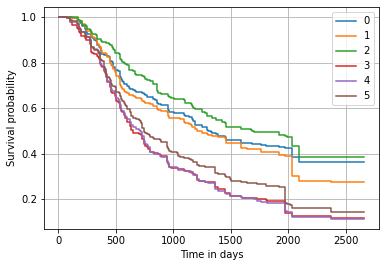

In [8]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

Alternatively, we can also plot the predicted cumulative hazard function.

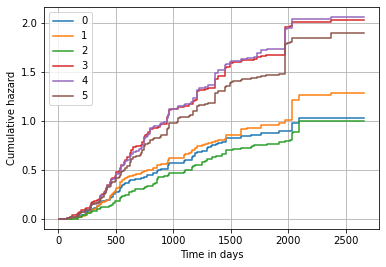

In [9]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Permutation-based Feature Importance

The implementation is based on scikit-learn's Random Forest implementation and inherits many
features, such as building trees in parallel. What's currently missing is feature importances
via the `feature_importance_` attribute.
This is due to the way scikit-learn's implementation computes importances. It relies on
a measure of *impurity* for each child node, and defines importance as the amount of
decrease in impurity due to a split. For traditional regression, impurity would be measured by the variance, but for survival analysis
there is no per-node impurity measure due to censoring. Instead, one could use the
magnitude of the log-rank test statistic as an importance measure, but scikit-learn's
implementation doesn't seem to allow this.

Fortunately, this is not a big concern though, as scikit-learn's definition
of feature importance is non-standard and differs from what Leo Breiman
[proposed in the original Random Forest paper](https://github.com/scikit-learn/scikit-learn/pull/8027#issuecomment-327595859).
Instead, we can use permutation to estimate feature importance, which is
preferred over scikit-learn's definition. This is implemented in the
[permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)
function of scikit-learn,
which is fully compatible with scikit-survival.

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [11]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
pnodes,0.077655,0.019356
age,0.015749,0.008232
progrec,0.009565,0.013541
horTh=yes,0.006289,0.004057
tgrade,0.003346,0.003764
menostat=Post,0.000070,0.001023
tsize,-0.000070,0.009698
estrec,-0.008220,0.009413


The result shows that the number of positive lymph nodes (`pnodes`) is by far the most important
feature. If its relationship to survival time is removed (by random shuffling),
the concordance index on the test data drops on average by 0.077655 points.
Again, this agrees with the results from the original
[Random Survival Forests paper](https://projecteuclid.org/euclid.aoas/1223908043).